In [1]:
import torch, torchvision
print(torch.__version__)
print(torch.cuda.is_available())

1.12.1+cu113
True


In [ ]:
! nvidia-smi

Sun Sep 11 07:22:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install mmcv -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html
     |████████████████████████████████| 563 kB 14.3 MB/s 
     |████████████████████████████████| 190 kB 69.5 MB/s 
  Created wheel for mmcv: filename=mmcv-1.6.1-py2.py3-none-any.whl size=860296 sha256=15aec9ed2d166cf1febf2bc223a1c921a8e5a783230b802f47909407dd6b38fb
  Stored in directory: /root/.cache/pip/wheels/e0/43/68/40160e8aa085d474903f0ad3764bac92e698936bfcf8a5454b
Successfully built mmcv


In [ ]:
# !git clone https://github.com/open-mmlab/mmclassification.git
%cd /content/drive/MyDrive/mmclassification/

/content/drive/MyDrive/mmclassification


In [ ]:
!pip install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/drive/MyDrive/mmclassification
  Attempting uninstall: mmcls
    Found existing installation: mmcls 0.23.2
    Can't uninstall 'mmcls'. No files were found to uninstall.
  Running setup.py develop for mmcls


In [ ]:
import mmcls
print(mmcls.__version__)

ModuleNotFoundError: ignored

In [ ]:
! ls configs/mobilenet_v2/mobilenet-v2_8xb32_in1k.py

configs/mobilenet_v2/mobilenet-v2_8xb32_in1k.py


In [ ]:
config_file = 'configs/vision_transformer/vit-base-p16_ft-64xb64_in1k-384.py'
checkpoint_file = 'https://download.openmmlab.com/mmclassification/v0/vit/finetune/vit-base-p16_in21k-pre-3rdparty_ft-64xb64_in1k-384_20210928-98e8652b.pth'

In [ ]:
import mmcv
from mmcls.apis import inference_model, init_model, show_result_pyplot

/usr/local/lib/python3.7/dist-packages/mmcv/cnn/bricks/transformer.py:33: UserWarning: Fail to import ``MultiScaleDeformableAttention`` from ``mmcv.ops.multi_scale_deform_attn``, You should install ``mmcv-full`` if you need this module. 
  warnings.warn('Fail to import ``MultiScaleDeformableAttention`` from '


In [ ]:
device = 'cuda'

In [ ]:
# Build the model according to the config file and load the checkpoint.
model = init_model(config_file, checkpoint_file, device=device)

load checkpoint from http path: https://download.openmmlab.com/mmclassification/v0/vit/finetune/vit-base-p16_in21k-pre-3rdparty_ft-64xb64_in1k-384_20210928-98e8652b.pth


/content/drive/MyDrive/mmclassification/mmcls/apis/inference.py:45: UserWarning: Class names are not saved in the checkpoint's meta data, use imagenet by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


In [ ]:
# The model's inheritance relationship
model.__class__.__mro__

(mmcls.models.classifiers.image.ImageClassifier,
 mmcls.models.classifiers.base.BaseClassifier,
 mmcv.runner.base_module.BaseModule,
 torch.nn.modules.module.Module,
 object)

In [ ]:
# config_file = 'configs/mobilenet_v2/mobilenet-v2_8xb32_in1k.py'
# Load the base config file
from mmcv import Config
cfg = Config.fromfile(config_file)
# Modify the number of classes in the head.
cfg.model.head.num_classes = 6
cfg.model.head.topk = (1, )


# Load the pre-trained model's checkpoint.
cfg.model.backbone.init_cfg = dict(type='Pretrained', checkpoint=checkpoint_file, prefix='backbone')

# Specify sample size and number of workers.
cfg.data.samples_per_gpu = 16
cfg.data.workers_per_gpu = 1

# Specify the path and meta files of training dataset
cfg.data.train.data_prefix = '/content/drive/MyDrive/export/mmclass/train/'
cfg.data.train.classes = '/content/drive/MyDrive/export/mmclass/meta/classes.txt'
# cfg.data.train.ann_file = '/content/drive/MyDrive/export/train_0829.txt'

# Specify the path and meta files of validation dataset
cfg.data.val.data_prefix = '/content/drive/MyDrive/export/mmclass/val/'
cfg.data.val.classes = '/content/drive/MyDrive/export/mmclass/meta/classes.txt'
cfg.data.val.ann_file = "/content/drive/MyDrive/export/mmclass/meta/val_0911_crop_class_google.txt"

# Specify the path and meta files of test dataset
cfg.data.test.data_prefix = '/content/drive/MyDrive/export/mmclass/test/'
cfg.data.test.classes = '/content/drive/MyDrive/export/mmclass/meta/classes.txt'
cfg.data.test.ann_file = "/content/drive/MyDrive/export/mmclass/meta/test_0911_crop_class_google.txt"


# Specify the normalization parameters in data pipeline
normalize_cfg = dict(type='Normalize', mean=[124.508, 116.050, 106.438], std=[58.577, 57.310, 57.437], to_rgb=True)
cfg.data.train.pipeline[3] = normalize_cfg
cfg.data.val.pipeline[3] = normalize_cfg
cfg.data.test.pipeline[3] = normalize_cfg

# Modify the evaluation metric
cfg.evaluation['metric_options']={'topk': (1, )}

# Specify the optimizer
cfg.optimizer = dict(type='SGD', lr=0.005, momentum=0.9, weight_decay=0.0001)
cfg.optimizer_config = dict(grad_clip=None)

# Specify the learning rate scheduler
cfg.lr_config = dict(policy='step', step=1, gamma=0.1)
cfg.runner = dict(type='EpochBasedRunner', max_epochs=50)

# Specify the work directory
cfg.work_dir = './work_dirs/vit'

# Output logs for every 10 iterations
cfg.log_config.interval = 10

# Set the random seed and enable the deterministic option of cuDNN
# to keep the results' reproducible.
from mmcls.apis import set_random_seed
cfg.seed = 0
set_random_seed(0, deterministic=True)

cfg.gpu_ids = range(1)
cfg.device = "cuda"
cfg.model.backbone.img_size= 224

In [ ]:
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='ImageClassifier',
    backbone=dict(
        type='VisionTransformer',
        arch='b',
        img_size=224,
        patch_size=16,
        drop_rate=0.1,
        init_cfg=dict(
            type='Pretrained',
            checkpoint=
            'https://download.openmmlab.com/mmclassification/v0/vit/finetune/vit-base-p16_in21k-pre-3rdparty_ft-64xb64_in1k-384_20210928-98e8652b.pth',
            prefix='backbone')),
    neck=None,
    head=dict(
        type='VisionTransformerClsHead',
        num_classes=6,
        in_channels=768,
        loss=dict(
            type='LabelSmoothLoss', label_smooth_val=0.1,
            mode='classy_vision'),
        topk=(1, )))
policy_imagenet = [[{
    'type': 'Posterize',
    'bits': 4,
    'prob': 0.4
}, {
    'type': 'Rotate',
    'angle': 30.0,
    'prob': 0.6
}],
                   [{
                       'type': 'Solarize',
                       'thr': 113.77777777777777,
                       'prob': 0.6
  

In [ ]:
import time
import mmcv
import os.path as osp

from mmcls.datasets import build_dataset
from mmcls.models import build_classifier
from mmcls.apis import train_model

# Create the work directory
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
# Build the classifier
model = build_classifier(cfg.model)
model.init_weights()
# Build the dataset
datasets = [build_dataset(cfg.data.train)]
# Add `CLASSES` attributes to help visualization
model.CLASSES = datasets[0].CLASSES
# # # Start fine-tuning
train_model(
    model,
    datasets,
    cfg,
    distributed=False,
    validate=True,
    timestamp=time.strftime('%Y%m%d_%H%M%S', time.localtime()),
    meta=dict())

2022-09-15 08:07:48,697 - mmcv - INFO - initialize VisionTransformer with init_cfg {'type': 'Pretrained', 'checkpoint': 'https://download.openmmlab.com/mmclassification/v0/vit/finetune/vit-base-p16_in21k-pre-3rdparty_ft-64xb64_in1k-384_20210928-98e8652b.pth', 'prefix': 'backbone'}
2022-09-15 08:07:48,699 - mmcv - INFO - load backbone in model from: https://download.openmmlab.com/mmclassification/v0/vit/finetune/vit-base-p16_in21k-pre-3rdparty_ft-64xb64_in1k-384_20210928-98e8652b.pth


load checkpoint from http path: https://download.openmmlab.com/mmclassification/v0/vit/finetune/vit-base-p16_in21k-pre-3rdparty_ft-64xb64_in1k-384_20210928-98e8652b.pth


2022-09-15 08:07:48,908 - mmcls - INFO - Resize the pos_embed shape from torch.Size([1, 577, 768]) to torch.Size([1, 197, 768]).
2022-09-15 08:07:49,129 - mmcv - INFO - initialize VisionTransformerClsHead with init_cfg {'type': 'Constant', 'layer': 'Linear', 'val': 0}
2022-09-15 08:07:49,132 - mmcv - INFO - 
backbone.cls_token - torch.Size([1, 1, 768]): 
PretrainedInit: load from https://download.openmmlab.com/mmclassification/v0/vit/finetune/vit-base-p16_in21k-pre-3rdparty_ft-64xb64_in1k-384_20210928-98e8652b.pth 
 
2022-09-15 08:07:49,133 - mmcv - INFO - 
backbone.pos_embed - torch.Size([1, 197, 768]): 
PretrainedInit: load from https://download.openmmlab.com/mmclassification/v0/vit/finetune/vit-base-p16_in21k-pre-3rdparty_ft-64xb64_in1k-384_20210928-98e8652b.pth 
 
2022-09-15 08:07:49,134 - mmcv - INFO - 
backbone.patch_embed.projection.weight - torch.Size([768, 3, 16, 16]): 
PretrainedInit: load from https://download.openmmlab.com/mmclassification/v0/vit/finetune/vit-base-p16_in21k

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 1.7 task/s, elapsed: 729s, ETA:     0s

2022-09-15 08:56:49,324 - mmcls - INFO - Epoch(val) [1][79]	accuracy_top-1: 12.8000
2022-09-15 08:57:01,229 - mmcls - INFO - Epoch [2][10/313]	lr: 5.000e-04, eta: 1 day, 4:55:56, time: 1.151, data_time: 0.261, memory: 10064, loss: 1.0265
2022-09-15 08:57:10,534 - mmcls - INFO - Epoch [2][20/313]	lr: 5.000e-04, eta: 1 day, 4:09:50, time: 0.930, data_time: 0.040, memory: 10064, loss: 1.0993
2022-09-15 08:57:19,831 - mmcls - INFO - Epoch [2][30/313]	lr: 5.000e-04, eta: 1 day, 3:26:25, time: 0.930, data_time: 0.040, memory: 10064, loss: 1.0291
2022-09-15 08:57:29,147 - mmcls - INFO - Epoch [2][40/313]	lr: 5.000e-04, eta: 1 day, 2:45:27, time: 0.931, data_time: 0.040, memory: 10064, loss: 1.0806
2022-09-15 08:57:38,463 - mmcls - INFO - Epoch [2][50/313]	lr: 5.000e-04, eta: 1 day, 2:06:45, time: 0.932, data_time: 0.040, memory: 10064, loss: 0.9670
2022-09-15 08:57:47,781 - mmcls - INFO - Epoch [2][60/313]	lr: 5.000e-04, eta: 1 day, 1:30:06, time: 0.932, data_time: 0.040, memory: 10064, loss:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.4 task/s, elapsed: 34s, ETA:     0s

2022-09-15 09:02:21,484 - mmcls - INFO - Epoch(val) [2][79]	accuracy_top-1: 7.7600
2022-09-15 09:02:33,302 - mmcls - INFO - Epoch [3][10/313]	lr: 5.000e-05, eta: 16:17:57, time: 1.142, data_time: 0.253, memory: 10064, loss: 0.9478
2022-09-15 09:02:42,605 - mmcls - INFO - Epoch [3][20/313]	lr: 5.000e-05, eta: 16:05:46, time: 0.930, data_time: 0.040, memory: 10064, loss: 0.9117
2022-09-15 09:02:51,904 - mmcls - INFO - Epoch [3][30/313]	lr: 5.000e-05, eta: 15:53:57, time: 0.930, data_time: 0.040, memory: 10064, loss: 0.9166
2022-09-15 09:03:01,217 - mmcls - INFO - Epoch [3][40/313]	lr: 5.000e-05, eta: 15:42:30, time: 0.932, data_time: 0.041, memory: 10064, loss: 0.9993
2022-09-15 09:03:10,520 - mmcls - INFO - Epoch [3][50/313]	lr: 5.000e-05, eta: 15:31:22, time: 0.930, data_time: 0.040, memory: 10064, loss: 0.9520
2022-09-15 09:03:19,831 - mmcls - INFO - Epoch [3][60/313]	lr: 5.000e-05, eta: 15:20:34, time: 0.932, data_time: 0.040, memory: 10064, loss: 0.9543
2022-09-15 09:03:29,127 - mmc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.4 task/s, elapsed: 34s, ETA:     0s

2022-09-15 09:07:52,384 - mmcls - INFO - Epoch(val) [3][79]	accuracy_top-1: 7.2800
2022-09-15 09:08:04,105 - mmcls - INFO - Epoch [4][10/313]	lr: 5.000e-06, eta: 11:56:45, time: 1.133, data_time: 0.242, memory: 10064, loss: 0.8485
2022-09-15 09:08:13,418 - mmcls - INFO - Epoch [4][20/313]	lr: 5.000e-06, eta: 11:51:11, time: 0.931, data_time: 0.039, memory: 10064, loss: 1.0360
2022-09-15 09:08:22,742 - mmcls - INFO - Epoch [4][30/313]	lr: 5.000e-06, eta: 11:45:43, time: 0.932, data_time: 0.040, memory: 10064, loss: 0.9472
2022-09-15 09:08:32,048 - mmcls - INFO - Epoch [4][40/313]	lr: 5.000e-06, eta: 11:40:21, time: 0.931, data_time: 0.040, memory: 10064, loss: 0.9200
2022-09-15 09:08:41,366 - mmcls - INFO - Epoch [4][50/313]	lr: 5.000e-06, eta: 11:35:06, time: 0.932, data_time: 0.040, memory: 10064, loss: 0.9266
2022-09-15 09:08:50,669 - mmcls - INFO - Epoch [4][60/313]	lr: 5.000e-06, eta: 11:29:57, time: 0.930, data_time: 0.040, memory: 10064, loss: 0.9608
2022-09-15 09:08:59,986 - mmc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.5 task/s, elapsed: 34s, ETA:     0s

2022-09-15 09:13:25,439 - mmcls - INFO - Epoch(val) [4][79]	accuracy_top-1: 7.2000
2022-09-15 09:13:37,248 - mmcls - INFO - Epoch [5][10/313]	lr: 5.000e-07, eta: 9:42:46, time: 1.141, data_time: 0.250, memory: 10064, loss: 0.9648
2022-09-15 09:13:46,564 - mmcls - INFO - Epoch [5][20/313]	lr: 5.000e-07, eta: 9:39:32, time: 0.932, data_time: 0.040, memory: 10064, loss: 0.9771
2022-09-15 09:13:55,877 - mmcls - INFO - Epoch [5][30/313]	lr: 5.000e-07, eta: 9:36:21, time: 0.931, data_time: 0.040, memory: 10064, loss: 0.9794
2022-09-15 09:14:05,205 - mmcls - INFO - Epoch [5][40/313]	lr: 5.000e-07, eta: 9:33:13, time: 0.933, data_time: 0.040, memory: 10064, loss: 0.9543
2022-09-15 09:14:14,512 - mmcls - INFO - Epoch [5][50/313]	lr: 5.000e-07, eta: 9:30:08, time: 0.931, data_time: 0.040, memory: 10064, loss: 0.8125
2022-09-15 09:14:23,822 - mmcls - INFO - Epoch [5][60/313]	lr: 5.000e-07, eta: 9:27:05, time: 0.930, data_time: 0.040, memory: 10064, loss: 0.8976
2022-09-15 09:14:33,144 - mmcls - I

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.7 task/s, elapsed: 34s, ETA:     0s

2022-09-15 09:18:56,151 - mmcls - INFO - Epoch(val) [5][79]	accuracy_top-1: 7.2000
2022-09-15 09:19:07,858 - mmcls - INFO - Epoch [6][10/313]	lr: 5.000e-08, eta: 8:20:06, time: 1.131, data_time: 0.238, memory: 10064, loss: 0.9920
2022-09-15 09:19:17,162 - mmcls - INFO - Epoch [6][20/313]	lr: 5.000e-08, eta: 8:17:58, time: 0.930, data_time: 0.040, memory: 10064, loss: 0.9403
2022-09-15 09:19:26,487 - mmcls - INFO - Epoch [6][30/313]	lr: 5.000e-08, eta: 8:15:52, time: 0.932, data_time: 0.040, memory: 10064, loss: 0.9014
2022-09-15 09:19:35,808 - mmcls - INFO - Epoch [6][40/313]	lr: 5.000e-08, eta: 8:13:47, time: 0.932, data_time: 0.040, memory: 10064, loss: 0.8657
2022-09-15 09:19:45,118 - mmcls - INFO - Epoch [6][50/313]	lr: 5.000e-08, eta: 8:11:44, time: 0.931, data_time: 0.040, memory: 10064, loss: 0.9233
2022-09-15 09:19:54,430 - mmcls - INFO - Epoch [6][60/313]	lr: 5.000e-08, eta: 8:09:42, time: 0.931, data_time: 0.039, memory: 10064, loss: 1.0344
2022-09-15 09:20:03,750 - mmcls - I

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.8 task/s, elapsed: 34s, ETA:     0s

2022-09-15 09:24:26,696 - mmcls - INFO - Epoch(val) [6][79]	accuracy_top-1: 7.2000
2022-09-15 09:24:38,410 - mmcls - INFO - Epoch [7][10/313]	lr: 5.000e-09, eta: 7:23:15, time: 1.132, data_time: 0.239, memory: 10064, loss: 0.9837
2022-09-15 09:24:47,725 - mmcls - INFO - Epoch [7][20/313]	lr: 5.000e-09, eta: 7:21:43, time: 0.932, data_time: 0.040, memory: 10064, loss: 0.9411
2022-09-15 09:24:57,046 - mmcls - INFO - Epoch [7][30/313]	lr: 5.000e-09, eta: 7:20:12, time: 0.932, data_time: 0.040, memory: 10064, loss: 0.9543
2022-09-15 09:25:06,368 - mmcls - INFO - Epoch [7][40/313]	lr: 5.000e-09, eta: 7:18:42, time: 0.932, data_time: 0.040, memory: 10064, loss: 0.9902
2022-09-15 09:25:15,681 - mmcls - INFO - Epoch [7][50/313]	lr: 5.000e-09, eta: 7:17:13, time: 0.931, data_time: 0.040, memory: 10064, loss: 0.8665
2022-09-15 09:25:24,998 - mmcls - INFO - Epoch [7][60/313]	lr: 5.000e-09, eta: 7:15:44, time: 0.932, data_time: 0.040, memory: 10064, loss: 0.9208
2022-09-15 09:25:34,320 - mmcls - I

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.8 task/s, elapsed: 34s, ETA:     0s

2022-09-15 09:29:57,373 - mmcls - INFO - Epoch(val) [7][79]	accuracy_top-1: 7.2000
2022-09-15 09:30:09,169 - mmcls - INFO - Epoch [8][10/313]	lr: 5.000e-10, eta: 6:41:12, time: 1.139, data_time: 0.248, memory: 10064, loss: 0.9501
2022-09-15 09:30:18,492 - mmcls - INFO - Epoch [8][20/313]	lr: 5.000e-10, eta: 6:40:02, time: 0.932, data_time: 0.040, memory: 10064, loss: 0.9292
2022-09-15 09:30:27,802 - mmcls - INFO - Epoch [8][30/313]	lr: 5.000e-10, eta: 6:38:52, time: 0.931, data_time: 0.040, memory: 10064, loss: 0.9112
2022-09-15 09:30:37,116 - mmcls - INFO - Epoch [8][40/313]	lr: 5.000e-10, eta: 6:37:43, time: 0.931, data_time: 0.040, memory: 10064, loss: 1.1117
2022-09-15 09:30:46,449 - mmcls - INFO - Epoch [8][50/313]	lr: 5.000e-10, eta: 6:36:35, time: 0.933, data_time: 0.040, memory: 10064, loss: 0.9600
2022-09-15 09:30:55,775 - mmcls - INFO - Epoch [8][60/313]	lr: 5.000e-10, eta: 6:35:27, time: 0.932, data_time: 0.040, memory: 10064, loss: 0.9230
2022-09-15 09:31:05,098 - mmcls - I

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.8 task/s, elapsed: 34s, ETA:     0s

2022-09-15 09:35:28,222 - mmcls - INFO - Epoch(val) [8][79]	accuracy_top-1: 7.2000
2022-09-15 09:35:39,963 - mmcls - INFO - Epoch [9][10/313]	lr: 5.000e-11, eta: 6:08:25, time: 1.134, data_time: 0.243, memory: 10064, loss: 1.0593
2022-09-15 09:35:49,293 - mmcls - INFO - Epoch [9][20/313]	lr: 5.000e-11, eta: 6:07:29, time: 0.933, data_time: 0.040, memory: 10064, loss: 0.8867
2022-09-15 09:35:58,617 - mmcls - INFO - Epoch [9][30/313]	lr: 5.000e-11, eta: 6:06:34, time: 0.932, data_time: 0.040, memory: 10064, loss: 0.9563
2022-09-15 09:36:07,932 - mmcls - INFO - Epoch [9][40/313]	lr: 5.000e-11, eta: 6:05:38, time: 0.932, data_time: 0.040, memory: 10064, loss: 0.9744
2022-09-15 09:36:17,254 - mmcls - INFO - Epoch [9][50/313]	lr: 5.000e-11, eta: 6:04:44, time: 0.932, data_time: 0.040, memory: 10064, loss: 0.9867
2022-09-15 09:36:26,587 - mmcls - INFO - Epoch [9][60/313]	lr: 5.000e-11, eta: 6:03:49, time: 0.933, data_time: 0.040, memory: 10064, loss: 0.8943
2022-09-15 09:36:35,912 - mmcls - I

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.5 task/s, elapsed: 34s, ETA:     0s

2022-09-15 09:40:59,151 - mmcls - INFO - Epoch(val) [9][79]	accuracy_top-1: 7.2000
2022-09-15 09:41:10,884 - mmcls - INFO - Epoch [10][10/313]	lr: 5.000e-12, eta: 5:41:49, time: 1.134, data_time: 0.241, memory: 10064, loss: 0.9807
2022-09-15 09:41:20,202 - mmcls - INFO - Epoch [10][20/313]	lr: 5.000e-12, eta: 5:41:03, time: 0.932, data_time: 0.040, memory: 10064, loss: 1.0326
2022-09-15 09:41:29,524 - mmcls - INFO - Epoch [10][30/313]	lr: 5.000e-12, eta: 5:40:17, time: 0.932, data_time: 0.040, memory: 10064, loss: 0.8300
2022-09-15 09:41:38,841 - mmcls - INFO - Epoch [10][40/313]	lr: 5.000e-12, eta: 5:39:31, time: 0.932, data_time: 0.040, memory: 10064, loss: 0.9403
2022-09-15 09:41:48,155 - mmcls - INFO - Epoch [10][50/313]	lr: 5.000e-12, eta: 5:38:46, time: 0.932, data_time: 0.040, memory: 10064, loss: 0.9055
2022-09-15 09:41:57,460 - mmcls - INFO - Epoch [10][60/313]	lr: 5.000e-12, eta: 5:38:01, time: 0.931, data_time: 0.040, memory: 10064, loss: 0.8879
2022-09-15 09:42:06,785 - mmc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.4 task/s, elapsed: 34s, ETA:     0s

2022-09-15 09:46:30,067 - mmcls - INFO - Epoch(val) [10][79]	accuracy_top-1: 7.2000
2022-09-15 09:46:41,787 - mmcls - INFO - Epoch [11][10/313]	lr: 5.000e-13, eta: 5:19:32, time: 1.132, data_time: 0.240, memory: 10064, loss: 0.9702
2022-09-15 09:46:51,094 - mmcls - INFO - Epoch [11][20/313]	lr: 5.000e-13, eta: 5:18:53, time: 0.931, data_time: 0.040, memory: 10064, loss: 0.9313
2022-09-15 09:47:00,432 - mmcls - INFO - Epoch [11][30/313]	lr: 5.000e-13, eta: 5:18:14, time: 0.934, data_time: 0.041, memory: 10064, loss: 0.9100
2022-09-15 09:47:09,732 - mmcls - INFO - Epoch [11][40/313]	lr: 5.000e-13, eta: 5:17:35, time: 0.930, data_time: 0.040, memory: 10064, loss: 1.0083
2022-09-15 09:47:19,048 - mmcls - INFO - Epoch [11][50/313]	lr: 5.000e-13, eta: 5:16:57, time: 0.931, data_time: 0.040, memory: 10064, loss: 0.9581
2022-09-15 09:47:28,347 - mmcls - INFO - Epoch [11][60/313]	lr: 5.000e-13, eta: 5:16:18, time: 0.930, data_time: 0.040, memory: 10064, loss: 0.9035
2022-09-15 09:47:37,663 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.4 task/s, elapsed: 34s, ETA:     0s

2022-09-15 09:52:00,957 - mmcls - INFO - Epoch(val) [11][79]	accuracy_top-1: 7.2000
2022-09-15 09:52:12,751 - mmcls - INFO - Epoch [12][10/313]	lr: 5.000e-14, eta: 5:00:25, time: 1.140, data_time: 0.249, memory: 10064, loss: 0.9113
2022-09-15 09:52:22,072 - mmcls - INFO - Epoch [12][20/313]	lr: 5.000e-14, eta: 4:59:51, time: 0.932, data_time: 0.040, memory: 10064, loss: 0.9801
2022-09-15 09:52:31,379 - mmcls - INFO - Epoch [12][30/313]	lr: 5.000e-14, eta: 4:59:17, time: 0.930, data_time: 0.040, memory: 10064, loss: 0.9584
2022-09-15 09:52:40,680 - mmcls - INFO - Epoch [12][40/313]	lr: 5.000e-14, eta: 4:58:44, time: 0.930, data_time: 0.040, memory: 10064, loss: 0.9503
2022-09-15 09:52:50,000 - mmcls - INFO - Epoch [12][50/313]	lr: 5.000e-14, eta: 4:58:10, time: 0.932, data_time: 0.040, memory: 10064, loss: 0.9309
2022-09-15 09:52:59,321 - mmcls - INFO - Epoch [12][60/313]	lr: 5.000e-14, eta: 4:57:37, time: 0.932, data_time: 0.040, memory: 10064, loss: 0.9367
2022-09-15 09:53:08,628 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.5 task/s, elapsed: 34s, ETA:     0s

2022-09-15 09:57:31,824 - mmcls - INFO - Epoch(val) [12][79]	accuracy_top-1: 7.2000
2022-09-15 09:57:43,540 - mmcls - INFO - Epoch [13][10/313]	lr: 5.000e-15, eta: 4:43:40, time: 1.132, data_time: 0.241, memory: 10064, loss: 0.9241
2022-09-15 09:57:52,857 - mmcls - INFO - Epoch [13][20/313]	lr: 5.000e-15, eta: 4:43:10, time: 0.932, data_time: 0.040, memory: 10064, loss: 0.9054
2022-09-15 09:58:02,175 - mmcls - INFO - Epoch [13][30/313]	lr: 5.000e-15, eta: 4:42:40, time: 0.932, data_time: 0.040, memory: 10064, loss: 0.8846
2022-09-15 09:58:11,487 - mmcls - INFO - Epoch [13][40/313]	lr: 5.000e-15, eta: 4:42:10, time: 0.931, data_time: 0.040, memory: 10064, loss: 0.9471
2022-09-15 09:58:20,792 - mmcls - INFO - Epoch [13][50/313]	lr: 5.000e-15, eta: 4:41:41, time: 0.930, data_time: 0.040, memory: 10064, loss: 1.0061
2022-09-15 09:58:30,102 - mmcls - INFO - Epoch [13][60/313]	lr: 5.000e-15, eta: 4:41:11, time: 0.931, data_time: 0.040, memory: 10064, loss: 0.9026
2022-09-15 09:58:39,420 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.6 task/s, elapsed: 34s, ETA:     0s

2022-09-15 10:03:02,405 - mmcls - INFO - Epoch(val) [13][79]	accuracy_top-1: 7.2000
2022-09-15 10:03:14,272 - mmcls - INFO - Epoch [14][10/313]	lr: 5.000e-16, eta: 4:28:45, time: 1.147, data_time: 0.254, memory: 10064, loss: 0.9808
2022-09-15 10:03:23,586 - mmcls - INFO - Epoch [14][20/313]	lr: 5.000e-16, eta: 4:28:18, time: 0.931, data_time: 0.040, memory: 10064, loss: 0.9629
2022-09-15 10:03:32,904 - mmcls - INFO - Epoch [14][30/313]	lr: 5.000e-16, eta: 4:27:51, time: 0.932, data_time: 0.041, memory: 10064, loss: 0.9160
2022-09-15 10:03:42,216 - mmcls - INFO - Epoch [14][40/313]	lr: 5.000e-16, eta: 4:27:24, time: 0.931, data_time: 0.040, memory: 10064, loss: 0.9889
2022-09-15 10:03:51,524 - mmcls - INFO - Epoch [14][50/313]	lr: 5.000e-16, eta: 4:26:58, time: 0.931, data_time: 0.040, memory: 10064, loss: 0.9912
2022-09-15 10:04:00,842 - mmcls - INFO - Epoch [14][60/313]	lr: 5.000e-16, eta: 4:26:31, time: 0.931, data_time: 0.040, memory: 10064, loss: 1.0440
2022-09-15 10:04:10,159 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.5 task/s, elapsed: 34s, ETA:     0s

2022-09-15 10:08:33,282 - mmcls - INFO - Epoch(val) [14][79]	accuracy_top-1: 7.2000
2022-09-15 10:08:45,095 - mmcls - INFO - Epoch [15][10/313]	lr: 5.000e-17, eta: 4:15:16, time: 1.142, data_time: 0.251, memory: 10064, loss: 1.0229
2022-09-15 10:08:54,408 - mmcls - INFO - Epoch [15][20/313]	lr: 5.000e-17, eta: 4:14:52, time: 0.931, data_time: 0.040, memory: 10064, loss: 1.0222
2022-09-15 10:09:03,706 - mmcls - INFO - Epoch [15][30/313]	lr: 5.000e-17, eta: 4:14:27, time: 0.930, data_time: 0.040, memory: 10064, loss: 0.8999
2022-09-15 10:09:13,019 - mmcls - INFO - Epoch [15][40/313]	lr: 5.000e-17, eta: 4:14:03, time: 0.931, data_time: 0.040, memory: 10064, loss: 0.9040
2022-09-15 10:09:22,329 - mmcls - INFO - Epoch [15][50/313]	lr: 5.000e-17, eta: 4:13:38, time: 0.930, data_time: 0.039, memory: 10064, loss: 0.9671
2022-09-15 10:09:31,633 - mmcls - INFO - Epoch [15][60/313]	lr: 5.000e-17, eta: 4:13:14, time: 0.931, data_time: 0.040, memory: 10064, loss: 0.9467
2022-09-15 10:09:40,953 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.5 task/s, elapsed: 34s, ETA:     0s

2022-09-15 10:14:04,168 - mmcls - INFO - Epoch(val) [15][79]	accuracy_top-1: 7.2000
2022-09-15 10:14:16,128 - mmcls - INFO - Epoch [16][10/313]	lr: 5.000e-18, eta: 4:02:57, time: 1.157, data_time: 0.266, memory: 10064, loss: 0.9564
2022-09-15 10:14:25,437 - mmcls - INFO - Epoch [16][20/313]	lr: 5.000e-18, eta: 4:02:34, time: 0.931, data_time: 0.040, memory: 10064, loss: 0.9477
2022-09-15 10:14:34,733 - mmcls - INFO - Epoch [16][30/313]	lr: 5.000e-18, eta: 4:02:11, time: 0.930, data_time: 0.040, memory: 10064, loss: 0.9767
2022-09-15 10:14:44,060 - mmcls - INFO - Epoch [16][40/313]	lr: 5.000e-18, eta: 4:01:49, time: 0.932, data_time: 0.040, memory: 10064, loss: 1.0245
2022-09-15 10:14:53,385 - mmcls - INFO - Epoch [16][50/313]	lr: 5.000e-18, eta: 4:01:26, time: 0.932, data_time: 0.040, memory: 10064, loss: 1.0145
2022-09-15 10:15:02,689 - mmcls - INFO - Epoch [16][60/313]	lr: 5.000e-18, eta: 4:01:04, time: 0.931, data_time: 0.040, memory: 10064, loss: 1.0073
2022-09-15 10:15:12,003 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.5 task/s, elapsed: 34s, ETA:     0s

2022-09-15 10:19:35,287 - mmcls - INFO - Epoch(val) [16][79]	accuracy_top-1: 7.2000
2022-09-15 10:19:47,064 - mmcls - INFO - Epoch [17][10/313]	lr: 5.000e-19, eta: 3:51:33, time: 1.138, data_time: 0.247, memory: 10064, loss: 0.9149
2022-09-15 10:19:56,373 - mmcls - INFO - Epoch [17][20/313]	lr: 5.000e-19, eta: 3:51:12, time: 0.931, data_time: 0.040, memory: 10064, loss: 0.8736
2022-09-15 10:20:05,675 - mmcls - INFO - Epoch [17][30/313]	lr: 5.000e-19, eta: 3:50:51, time: 0.930, data_time: 0.040, memory: 10064, loss: 0.9210
2022-09-15 10:20:14,978 - mmcls - INFO - Epoch [17][40/313]	lr: 5.000e-19, eta: 3:50:30, time: 0.931, data_time: 0.040, memory: 10064, loss: 1.0013
2022-09-15 10:20:24,318 - mmcls - INFO - Epoch [17][50/313]	lr: 5.000e-19, eta: 3:50:09, time: 0.934, data_time: 0.040, memory: 10064, loss: 1.0271
2022-09-15 10:20:33,637 - mmcls - INFO - Epoch [17][60/313]	lr: 5.000e-19, eta: 3:49:48, time: 0.932, data_time: 0.040, memory: 10064, loss: 1.0246
2022-09-15 10:20:42,964 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.6 task/s, elapsed: 34s, ETA:     0s

2022-09-15 10:25:06,065 - mmcls - INFO - Epoch(val) [17][79]	accuracy_top-1: 7.2000
2022-09-15 10:25:17,800 - mmcls - INFO - Epoch [18][10/313]	lr: 5.000e-20, eta: 3:40:55, time: 1.134, data_time: 0.244, memory: 10064, loss: 1.0401
2022-09-15 10:25:27,127 - mmcls - INFO - Epoch [18][20/313]	lr: 5.000e-20, eta: 3:40:35, time: 0.933, data_time: 0.040, memory: 10064, loss: 1.0159
2022-09-15 10:25:36,448 - mmcls - INFO - Epoch [18][30/313]	lr: 5.000e-20, eta: 3:40:16, time: 0.932, data_time: 0.040, memory: 10064, loss: 0.8561
2022-09-15 10:25:45,772 - mmcls - INFO - Epoch [18][40/313]	lr: 5.000e-20, eta: 3:39:56, time: 0.933, data_time: 0.040, memory: 10064, loss: 0.9766
2022-09-15 10:25:55,097 - mmcls - INFO - Epoch [18][50/313]	lr: 5.000e-20, eta: 3:39:37, time: 0.933, data_time: 0.040, memory: 10064, loss: 0.9709
2022-09-15 10:26:04,407 - mmcls - INFO - Epoch [18][60/313]	lr: 5.000e-20, eta: 3:39:17, time: 0.931, data_time: 0.040, memory: 10064, loss: 0.9591
2022-09-15 10:26:13,705 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.6 task/s, elapsed: 34s, ETA:     0s

2022-09-15 10:30:36,957 - mmcls - INFO - Epoch(val) [18][79]	accuracy_top-1: 7.2000
2022-09-15 10:30:48,676 - mmcls - INFO - Epoch [19][10/313]	lr: 5.000e-21, eta: 3:30:56, time: 1.132, data_time: 0.249, memory: 10064, loss: 0.9312
2022-09-15 10:30:58,000 - mmcls - INFO - Epoch [19][20/313]	lr: 5.000e-21, eta: 3:30:37, time: 0.932, data_time: 0.040, memory: 10064, loss: 0.9374
2022-09-15 10:31:07,304 - mmcls - INFO - Epoch [19][30/313]	lr: 5.000e-21, eta: 3:30:19, time: 0.931, data_time: 0.040, memory: 10064, loss: 0.9189
2022-09-15 10:31:16,623 - mmcls - INFO - Epoch [19][40/313]	lr: 5.000e-21, eta: 3:30:00, time: 0.931, data_time: 0.040, memory: 10064, loss: 1.0240
2022-09-15 10:31:25,931 - mmcls - INFO - Epoch [19][50/313]	lr: 5.000e-21, eta: 3:29:42, time: 0.932, data_time: 0.040, memory: 10064, loss: 0.9481
2022-09-15 10:31:35,247 - mmcls - INFO - Epoch [19][60/313]	lr: 5.000e-21, eta: 3:29:23, time: 0.931, data_time: 0.040, memory: 10064, loss: 0.9419
2022-09-15 10:31:44,563 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.6 task/s, elapsed: 34s, ETA:     0s

2022-09-15 10:36:07,808 - mmcls - INFO - Epoch(val) [19][79]	accuracy_top-1: 7.2000
2022-09-15 10:36:19,622 - mmcls - INFO - Epoch [20][10/313]	lr: 5.000e-22, eta: 3:21:29, time: 1.142, data_time: 0.249, memory: 10064, loss: 0.9344
2022-09-15 10:36:28,941 - mmcls - INFO - Epoch [20][20/313]	lr: 5.000e-22, eta: 3:21:11, time: 0.932, data_time: 0.040, memory: 10064, loss: 0.9247
2022-09-15 10:36:38,272 - mmcls - INFO - Epoch [20][30/313]	lr: 5.000e-22, eta: 3:20:54, time: 0.933, data_time: 0.040, memory: 10064, loss: 0.8912
2022-09-15 10:36:47,579 - mmcls - INFO - Epoch [20][40/313]	lr: 5.000e-22, eta: 3:20:36, time: 0.931, data_time: 0.040, memory: 10064, loss: 0.9376
2022-09-15 10:36:56,900 - mmcls - INFO - Epoch [20][50/313]	lr: 5.000e-22, eta: 3:20:19, time: 0.931, data_time: 0.040, memory: 10064, loss: 0.9491
2022-09-15 10:37:06,216 - mmcls - INFO - Epoch [20][60/313]	lr: 5.000e-22, eta: 3:20:01, time: 0.932, data_time: 0.040, memory: 10064, loss: 0.9083
2022-09-15 10:37:15,541 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.5 task/s, elapsed: 34s, ETA:     0s

2022-09-15 10:41:38,774 - mmcls - INFO - Epoch(val) [20][79]	accuracy_top-1: 7.2000
2022-09-15 10:41:50,572 - mmcls - INFO - Epoch [21][10/313]	lr: 5.000e-23, eta: 3:12:30, time: 1.140, data_time: 0.249, memory: 10064, loss: 0.8914
2022-09-15 10:41:59,883 - mmcls - INFO - Epoch [21][20/313]	lr: 5.000e-23, eta: 3:12:13, time: 0.931, data_time: 0.040, memory: 10064, loss: 0.9209
2022-09-15 10:42:09,203 - mmcls - INFO - Epoch [21][30/313]	lr: 5.000e-23, eta: 3:11:56, time: 0.932, data_time: 0.040, memory: 10064, loss: 0.8305
2022-09-15 10:42:18,514 - mmcls - INFO - Epoch [21][40/313]	lr: 5.000e-23, eta: 3:11:39, time: 0.931, data_time: 0.040, memory: 10064, loss: 0.9555
2022-09-15 10:42:27,842 - mmcls - INFO - Epoch [21][50/313]	lr: 5.000e-23, eta: 3:11:23, time: 0.933, data_time: 0.040, memory: 10064, loss: 1.0116
2022-09-15 10:42:37,151 - mmcls - INFO - Epoch [21][60/313]	lr: 5.000e-23, eta: 3:11:06, time: 0.931, data_time: 0.040, memory: 10064, loss: 0.9803
2022-09-15 10:42:46,461 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 37.0 task/s, elapsed: 34s, ETA:     0s

2022-09-15 10:47:09,242 - mmcls - INFO - Epoch(val) [21][79]	accuracy_top-1: 7.2000
2022-09-15 10:47:21,077 - mmcls - INFO - Epoch [22][10/313]	lr: 5.000e-24, eta: 3:03:54, time: 1.144, data_time: 0.250, memory: 10064, loss: 0.8967
2022-09-15 10:47:30,404 - mmcls - INFO - Epoch [22][20/313]	lr: 5.000e-24, eta: 3:03:38, time: 0.933, data_time: 0.040, memory: 10064, loss: 1.0509
2022-09-15 10:47:39,714 - mmcls - INFO - Epoch [22][30/313]	lr: 5.000e-24, eta: 3:03:22, time: 0.931, data_time: 0.040, memory: 10064, loss: 0.9454
2022-09-15 10:47:49,035 - mmcls - INFO - Epoch [22][40/313]	lr: 5.000e-24, eta: 3:03:06, time: 0.932, data_time: 0.040, memory: 10064, loss: 0.9633
2022-09-15 10:47:58,351 - mmcls - INFO - Epoch [22][50/313]	lr: 5.000e-24, eta: 3:02:50, time: 0.931, data_time: 0.040, memory: 10064, loss: 0.9172
2022-09-15 10:48:07,671 - mmcls - INFO - Epoch [22][60/313]	lr: 5.000e-24, eta: 3:02:34, time: 0.932, data_time: 0.040, memory: 10064, loss: 0.9782
2022-09-15 10:48:16,993 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.0 task/s, elapsed: 35s, ETA:     0s

2022-09-15 10:52:43,081 - mmcls - INFO - Epoch(val) [22][79]	accuracy_top-1: 7.2000
2022-09-15 10:52:54,838 - mmcls - INFO - Epoch [23][10/313]	lr: 5.000e-25, eta: 2:55:39, time: 1.136, data_time: 0.243, memory: 10064, loss: 1.0043
2022-09-15 10:53:04,154 - mmcls - INFO - Epoch [23][20/313]	lr: 5.000e-25, eta: 2:55:23, time: 0.931, data_time: 0.040, memory: 10064, loss: 0.9863
2022-09-15 10:53:13,471 - mmcls - INFO - Epoch [23][30/313]	lr: 5.000e-25, eta: 2:55:08, time: 0.932, data_time: 0.040, memory: 10064, loss: 0.9563
2022-09-15 10:53:22,768 - mmcls - INFO - Epoch [23][40/313]	lr: 5.000e-25, eta: 2:54:53, time: 0.929, data_time: 0.040, memory: 10064, loss: 0.8957
2022-09-15 10:53:32,101 - mmcls - INFO - Epoch [23][50/313]	lr: 5.000e-25, eta: 2:54:37, time: 0.933, data_time: 0.040, memory: 10064, loss: 0.9883
2022-09-15 10:53:41,423 - mmcls - INFO - Epoch [23][60/313]	lr: 5.000e-25, eta: 2:54:22, time: 0.932, data_time: 0.040, memory: 10064, loss: 0.9496
2022-09-15 10:53:50,732 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 37.3 task/s, elapsed: 34s, ETA:     0s

2022-09-15 10:58:13,263 - mmcls - INFO - Epoch(val) [23][79]	accuracy_top-1: 7.2000
2022-09-15 10:58:25,129 - mmcls - INFO - Epoch [24][10/313]	lr: 5.000e-26, eta: 2:47:41, time: 1.147, data_time: 0.254, memory: 10064, loss: 0.9958
2022-09-15 10:58:34,437 - mmcls - INFO - Epoch [24][20/313]	lr: 5.000e-26, eta: 2:47:27, time: 0.931, data_time: 0.040, memory: 10064, loss: 1.0091
2022-09-15 10:58:43,739 - mmcls - INFO - Epoch [24][30/313]	lr: 5.000e-26, eta: 2:47:12, time: 0.930, data_time: 0.040, memory: 10064, loss: 0.9478
2022-09-15 10:58:53,050 - mmcls - INFO - Epoch [24][40/313]	lr: 5.000e-26, eta: 2:46:57, time: 0.931, data_time: 0.040, memory: 10064, loss: 0.8874
2022-09-15 10:59:02,363 - mmcls - INFO - Epoch [24][50/313]	lr: 5.000e-26, eta: 2:46:42, time: 0.931, data_time: 0.039, memory: 10064, loss: 0.9153
2022-09-15 10:59:11,676 - mmcls - INFO - Epoch [24][60/313]	lr: 5.000e-26, eta: 2:46:27, time: 0.931, data_time: 0.040, memory: 10064, loss: 0.9344
2022-09-15 10:59:20,988 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 37.2 task/s, elapsed: 34s, ETA:     0s

2022-09-15 11:03:43,557 - mmcls - INFO - Epoch(val) [24][79]	accuracy_top-1: 7.2000
2022-09-15 11:03:55,682 - mmcls - INFO - Epoch [25][10/313]	lr: 5.000e-27, eta: 2:40:00, time: 1.173, data_time: 0.281, memory: 10064, loss: 0.9320
2022-09-15 11:04:04,997 - mmcls - INFO - Epoch [25][20/313]	lr: 5.000e-27, eta: 2:39:45, time: 0.931, data_time: 0.040, memory: 10064, loss: 0.9801
2022-09-15 11:04:14,326 - mmcls - INFO - Epoch [25][30/313]	lr: 5.000e-27, eta: 2:39:31, time: 0.933, data_time: 0.040, memory: 10064, loss: 0.9513
2022-09-15 11:04:23,652 - mmcls - INFO - Epoch [25][40/313]	lr: 5.000e-27, eta: 2:39:16, time: 0.932, data_time: 0.041, memory: 10064, loss: 0.9632
2022-09-15 11:04:32,972 - mmcls - INFO - Epoch [25][50/313]	lr: 5.000e-27, eta: 2:39:02, time: 0.932, data_time: 0.040, memory: 10064, loss: 0.8840
2022-09-15 11:04:42,262 - mmcls - INFO - Epoch [25][60/313]	lr: 5.000e-27, eta: 2:38:47, time: 0.929, data_time: 0.040, memory: 10064, loss: 0.9198
2022-09-15 11:04:51,562 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 37.2 task/s, elapsed: 34s, ETA:     0s

2022-09-15 11:09:14,122 - mmcls - INFO - Epoch(val) [25][79]	accuracy_top-1: 7.2000
2022-09-15 11:09:25,966 - mmcls - INFO - Epoch [26][10/313]	lr: 5.000e-28, eta: 2:32:31, time: 1.144, data_time: 0.253, memory: 10064, loss: 0.9141
2022-09-15 11:09:35,280 - mmcls - INFO - Epoch [26][20/313]	lr: 5.000e-28, eta: 2:32:17, time: 0.932, data_time: 0.040, memory: 10064, loss: 0.9179
2022-09-15 11:09:44,591 - mmcls - INFO - Epoch [26][30/313]	lr: 5.000e-28, eta: 2:32:03, time: 0.931, data_time: 0.040, memory: 10064, loss: 0.9578
2022-09-15 11:09:53,915 - mmcls - INFO - Epoch [26][40/313]	lr: 5.000e-28, eta: 2:31:49, time: 0.933, data_time: 0.040, memory: 10064, loss: 0.9517
2022-09-15 11:10:03,224 - mmcls - INFO - Epoch [26][50/313]	lr: 5.000e-28, eta: 2:31:35, time: 0.931, data_time: 0.040, memory: 10064, loss: 0.9393
2022-09-15 11:10:12,530 - mmcls - INFO - Epoch [26][60/313]	lr: 5.000e-28, eta: 2:31:21, time: 0.930, data_time: 0.040, memory: 10064, loss: 0.9582
2022-09-15 11:10:21,842 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 37.3 task/s, elapsed: 34s, ETA:     0s

2022-09-15 11:14:44,199 - mmcls - INFO - Epoch(val) [26][79]	accuracy_top-1: 7.2000
2022-09-15 11:14:55,857 - mmcls - INFO - Epoch [27][10/313]	lr: 5.000e-29, eta: 2:25:15, time: 1.126, data_time: 0.235, memory: 10090, loss: 0.9841
2022-09-15 11:15:05,169 - mmcls - INFO - Epoch [27][20/313]	lr: 5.000e-29, eta: 2:25:01, time: 0.931, data_time: 0.040, memory: 10090, loss: 1.0485
2022-09-15 11:15:14,483 - mmcls - INFO - Epoch [27][30/313]	lr: 5.000e-29, eta: 2:24:47, time: 0.932, data_time: 0.040, memory: 10090, loss: 0.9508
2022-09-15 11:15:23,801 - mmcls - INFO - Epoch [27][40/313]	lr: 5.000e-29, eta: 2:24:34, time: 0.932, data_time: 0.040, memory: 10090, loss: 0.9086
2022-09-15 11:15:33,115 - mmcls - INFO - Epoch [27][50/313]	lr: 5.000e-29, eta: 2:24:20, time: 0.931, data_time: 0.040, memory: 10090, loss: 0.9699
2022-09-15 11:15:42,415 - mmcls - INFO - Epoch [27][60/313]	lr: 5.000e-29, eta: 2:24:06, time: 0.930, data_time: 0.040, memory: 10090, loss: 0.8801
2022-09-15 11:15:51,716 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 37.1 task/s, elapsed: 34s, ETA:     0s

2022-09-15 11:20:14,227 - mmcls - INFO - Epoch(val) [27][79]	accuracy_top-1: 7.2000
2022-09-15 11:20:26,007 - mmcls - INFO - Epoch [28][10/313]	lr: 5.000e-30, eta: 2:18:09, time: 1.139, data_time: 0.249, memory: 10090, loss: 1.0065
2022-09-15 11:20:35,306 - mmcls - INFO - Epoch [28][20/313]	lr: 5.000e-30, eta: 2:17:56, time: 0.930, data_time: 0.040, memory: 10090, loss: 0.9612
2022-09-15 11:20:44,622 - mmcls - INFO - Epoch [28][30/313]	lr: 5.000e-30, eta: 2:17:42, time: 0.931, data_time: 0.040, memory: 10090, loss: 1.0488
2022-09-15 11:20:53,924 - mmcls - INFO - Epoch [28][40/313]	lr: 5.000e-30, eta: 2:17:29, time: 0.930, data_time: 0.040, memory: 10090, loss: 1.0003
2022-09-15 11:21:03,226 - mmcls - INFO - Epoch [28][50/313]	lr: 5.000e-30, eta: 2:17:15, time: 0.930, data_time: 0.040, memory: 10090, loss: 0.9498
2022-09-15 11:21:12,529 - mmcls - INFO - Epoch [28][60/313]	lr: 5.000e-30, eta: 2:17:02, time: 0.930, data_time: 0.040, memory: 10090, loss: 0.8703
2022-09-15 11:21:21,816 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 37.1 task/s, elapsed: 34s, ETA:     0s

2022-09-15 11:25:46,602 - mmcls - INFO - Epoch(val) [28][79]	accuracy_top-1: 7.2000
2022-09-15 11:25:58,368 - mmcls - INFO - Epoch [29][10/313]	lr: 5.000e-31, eta: 2:11:13, time: 1.137, data_time: 0.246, memory: 10090, loss: 0.9090
2022-09-15 11:26:07,689 - mmcls - INFO - Epoch [29][20/313]	lr: 5.000e-31, eta: 2:11:00, time: 0.932, data_time: 0.040, memory: 10090, loss: 0.9665
2022-09-15 11:26:17,000 - mmcls - INFO - Epoch [29][30/313]	lr: 5.000e-31, eta: 2:10:47, time: 0.931, data_time: 0.040, memory: 10090, loss: 0.9708
2022-09-15 11:26:26,307 - mmcls - INFO - Epoch [29][40/313]	lr: 5.000e-31, eta: 2:10:34, time: 0.931, data_time: 0.040, memory: 10090, loss: 1.0007
2022-09-15 11:26:35,613 - mmcls - INFO - Epoch [29][50/313]	lr: 5.000e-31, eta: 2:10:21, time: 0.931, data_time: 0.040, memory: 10090, loss: 0.9947
2022-09-15 11:26:44,916 - mmcls - INFO - Epoch [29][60/313]	lr: 5.000e-31, eta: 2:10:07, time: 0.931, data_time: 0.040, memory: 10090, loss: 0.9703
2022-09-15 11:26:54,228 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.6 task/s, elapsed: 34s, ETA:     0s

2022-09-15 11:31:17,270 - mmcls - INFO - Epoch(val) [29][79]	accuracy_top-1: 7.2000
2022-09-15 11:31:29,016 - mmcls - INFO - Epoch [30][10/313]	lr: 5.000e-32, eta: 2:04:26, time: 1.135, data_time: 0.244, memory: 10090, loss: 0.9500
2022-09-15 11:31:38,335 - mmcls - INFO - Epoch [30][20/313]	lr: 5.000e-32, eta: 2:04:13, time: 0.932, data_time: 0.041, memory: 10090, loss: 0.9459
2022-09-15 11:31:47,642 - mmcls - INFO - Epoch [30][30/313]	lr: 5.000e-32, eta: 2:04:00, time: 0.931, data_time: 0.040, memory: 10090, loss: 0.9164
2022-09-15 11:31:56,946 - mmcls - INFO - Epoch [30][40/313]	lr: 5.000e-32, eta: 2:03:47, time: 0.930, data_time: 0.040, memory: 10090, loss: 0.9837
2022-09-15 11:32:06,242 - mmcls - INFO - Epoch [30][50/313]	lr: 5.000e-32, eta: 2:03:34, time: 0.930, data_time: 0.040, memory: 10090, loss: 0.8869
2022-09-15 11:32:15,544 - mmcls - INFO - Epoch [30][60/313]	lr: 5.000e-32, eta: 2:03:21, time: 0.930, data_time: 0.040, memory: 10090, loss: 0.9395
2022-09-15 11:32:24,876 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.8 task/s, elapsed: 34s, ETA:     0s

2022-09-15 11:36:47,720 - mmcls - INFO - Epoch(val) [30][79]	accuracy_top-1: 7.2000
2022-09-15 11:36:59,463 - mmcls - INFO - Epoch [31][10/313]	lr: 5.000e-33, eta: 1:57:46, time: 1.135, data_time: 0.243, memory: 10090, loss: 0.9632
2022-09-15 11:37:08,769 - mmcls - INFO - Epoch [31][20/313]	lr: 5.000e-33, eta: 1:57:33, time: 0.930, data_time: 0.040, memory: 10090, loss: 0.8826
2022-09-15 11:37:18,089 - mmcls - INFO - Epoch [31][30/313]	lr: 5.000e-33, eta: 1:57:21, time: 0.932, data_time: 0.040, memory: 10090, loss: 1.0378
2022-09-15 11:37:27,393 - mmcls - INFO - Epoch [31][40/313]	lr: 5.000e-33, eta: 1:57:08, time: 0.930, data_time: 0.040, memory: 10090, loss: 0.9264
2022-09-15 11:37:36,717 - mmcls - INFO - Epoch [31][50/313]	lr: 5.000e-33, eta: 1:56:56, time: 0.933, data_time: 0.040, memory: 10090, loss: 0.8938
2022-09-15 11:37:46,041 - mmcls - INFO - Epoch [31][60/313]	lr: 5.000e-33, eta: 1:56:43, time: 0.932, data_time: 0.040, memory: 10090, loss: 0.9738
2022-09-15 11:37:55,363 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 35.7 task/s, elapsed: 35s, ETA:     0s

2022-09-15 11:42:19,248 - mmcls - INFO - Epoch(val) [31][79]	accuracy_top-1: 7.2000
2022-09-15 11:42:31,022 - mmcls - INFO - Epoch [32][10/313]	lr: 5.000e-34, eta: 1:51:13, time: 1.138, data_time: 0.247, memory: 10090, loss: 0.9517
2022-09-15 11:42:40,330 - mmcls - INFO - Epoch [32][20/313]	lr: 5.000e-34, eta: 1:51:01, time: 0.931, data_time: 0.040, memory: 10090, loss: 1.0194
2022-09-15 11:42:49,628 - mmcls - INFO - Epoch [32][30/313]	lr: 5.000e-34, eta: 1:50:49, time: 0.930, data_time: 0.040, memory: 10090, loss: 1.0125
2022-09-15 11:42:58,938 - mmcls - INFO - Epoch [32][40/313]	lr: 5.000e-34, eta: 1:50:36, time: 0.931, data_time: 0.040, memory: 10090, loss: 0.9578
2022-09-15 11:43:08,246 - mmcls - INFO - Epoch [32][50/313]	lr: 5.000e-34, eta: 1:50:24, time: 0.931, data_time: 0.040, memory: 10090, loss: 0.9102
2022-09-15 11:43:17,559 - mmcls - INFO - Epoch [32][60/313]	lr: 5.000e-34, eta: 1:50:11, time: 0.931, data_time: 0.040, memory: 10090, loss: 0.9228
2022-09-15 11:43:26,864 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 37.0 task/s, elapsed: 34s, ETA:     0s

2022-09-15 11:47:49,669 - mmcls - INFO - Epoch(val) [32][79]	accuracy_top-1: 7.2000
2022-09-15 11:48:01,500 - mmcls - INFO - Epoch [33][10/313]	lr: 5.000e-35, eta: 1:44:47, time: 1.144, data_time: 0.252, memory: 10090, loss: 0.9692
2022-09-15 11:48:10,819 - mmcls - INFO - Epoch [33][20/313]	lr: 5.000e-35, eta: 1:44:35, time: 0.932, data_time: 0.040, memory: 10090, loss: 0.9004
2022-09-15 11:48:20,137 - mmcls - INFO - Epoch [33][30/313]	lr: 5.000e-35, eta: 1:44:23, time: 0.932, data_time: 0.040, memory: 10090, loss: 0.9552
2022-09-15 11:48:29,459 - mmcls - INFO - Epoch [33][40/313]	lr: 5.000e-35, eta: 1:44:11, time: 0.932, data_time: 0.040, memory: 10090, loss: 1.0062
2022-09-15 11:48:38,761 - mmcls - INFO - Epoch [33][50/313]	lr: 5.000e-35, eta: 1:43:59, time: 0.930, data_time: 0.040, memory: 10090, loss: 0.9128
2022-09-15 11:48:48,074 - mmcls - INFO - Epoch [33][60/313]	lr: 5.000e-35, eta: 1:43:46, time: 0.932, data_time: 0.040, memory: 10090, loss: 0.8450
2022-09-15 11:48:57,393 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 35.6 task/s, elapsed: 35s, ETA:     0s

2022-09-15 11:53:23,787 - mmcls - INFO - Epoch(val) [33][79]	accuracy_top-1: 7.2000
2022-09-15 11:53:35,551 - mmcls - INFO - Epoch [34][10/313]	lr: 5.000e-36, eta: 1:38:27, time: 1.137, data_time: 0.246, memory: 10090, loss: 0.9288
2022-09-15 11:53:44,845 - mmcls - INFO - Epoch [34][20/313]	lr: 5.000e-36, eta: 1:38:15, time: 0.930, data_time: 0.040, memory: 10090, loss: 0.9704
2022-09-15 11:53:54,163 - mmcls - INFO - Epoch [34][30/313]	lr: 5.000e-36, eta: 1:38:03, time: 0.931, data_time: 0.040, memory: 10090, loss: 0.9580
2022-09-15 11:54:03,485 - mmcls - INFO - Epoch [34][40/313]	lr: 5.000e-36, eta: 1:37:51, time: 0.932, data_time: 0.040, memory: 10090, loss: 0.9348
2022-09-15 11:54:12,803 - mmcls - INFO - Epoch [34][50/313]	lr: 5.000e-36, eta: 1:37:39, time: 0.932, data_time: 0.040, memory: 10090, loss: 0.9270
2022-09-15 11:54:22,115 - mmcls - INFO - Epoch [34][60/313]	lr: 5.000e-36, eta: 1:37:27, time: 0.931, data_time: 0.040, memory: 10090, loss: 0.9574
2022-09-15 11:54:31,422 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.9 task/s, elapsed: 34s, ETA:     0s

2022-09-15 11:58:54,212 - mmcls - INFO - Epoch(val) [34][79]	accuracy_top-1: 7.2000
2022-09-15 11:59:05,891 - mmcls - INFO - Epoch [35][10/313]	lr: 5.000e-37, eta: 1:32:12, time: 1.128, data_time: 0.237, memory: 10090, loss: 1.0243
2022-09-15 11:59:15,210 - mmcls - INFO - Epoch [35][20/313]	lr: 5.000e-37, eta: 1:32:00, time: 0.932, data_time: 0.040, memory: 10090, loss: 0.8952
2022-09-15 11:59:24,516 - mmcls - INFO - Epoch [35][30/313]	lr: 5.000e-37, eta: 1:31:48, time: 0.930, data_time: 0.040, memory: 10090, loss: 0.9448
2022-09-15 11:59:33,825 - mmcls - INFO - Epoch [35][40/313]	lr: 5.000e-37, eta: 1:31:36, time: 0.931, data_time: 0.040, memory: 10090, loss: 0.9272
2022-09-15 11:59:43,135 - mmcls - INFO - Epoch [35][50/313]	lr: 5.000e-37, eta: 1:31:24, time: 0.931, data_time: 0.040, memory: 10090, loss: 0.9490
2022-09-15 11:59:52,446 - mmcls - INFO - Epoch [35][60/313]	lr: 5.000e-37, eta: 1:31:12, time: 0.931, data_time: 0.040, memory: 10090, loss: 1.0127
2022-09-15 12:00:01,761 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.1 task/s, elapsed: 35s, ETA:     0s

2022-09-15 12:04:25,367 - mmcls - INFO - Epoch(val) [35][79]	accuracy_top-1: 7.2000
2022-09-15 12:04:37,092 - mmcls - INFO - Epoch [36][10/313]	lr: 5.000e-38, eta: 1:26:02, time: 1.133, data_time: 0.247, memory: 10090, loss: 0.9620
2022-09-15 12:04:46,401 - mmcls - INFO - Epoch [36][20/313]	lr: 5.000e-38, eta: 1:25:50, time: 0.931, data_time: 0.040, memory: 10090, loss: 0.9785
2022-09-15 12:04:55,716 - mmcls - INFO - Epoch [36][30/313]	lr: 5.000e-38, eta: 1:25:38, time: 0.931, data_time: 0.040, memory: 10090, loss: 0.9828
2022-09-15 12:05:05,044 - mmcls - INFO - Epoch [36][40/313]	lr: 5.000e-38, eta: 1:25:26, time: 0.932, data_time: 0.041, memory: 10090, loss: 0.9305
2022-09-15 12:05:14,355 - mmcls - INFO - Epoch [36][50/313]	lr: 5.000e-38, eta: 1:25:15, time: 0.932, data_time: 0.040, memory: 10090, loss: 1.0026
2022-09-15 12:05:23,681 - mmcls - INFO - Epoch [36][60/313]	lr: 5.000e-38, eta: 1:25:03, time: 0.932, data_time: 0.040, memory: 10090, loss: 0.9273
2022-09-15 12:05:32,978 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 37.3 task/s, elapsed: 33s, ETA:     0s

2022-09-15 12:09:55,470 - mmcls - INFO - Epoch(val) [36][79]	accuracy_top-1: 7.2000
2022-09-15 12:10:07,273 - mmcls - INFO - Epoch [37][10/313]	lr: 5.000e-39, eta: 1:19:56, time: 1.140, data_time: 0.249, memory: 10090, loss: 0.8549
2022-09-15 12:10:16,579 - mmcls - INFO - Epoch [37][20/313]	lr: 5.000e-39, eta: 1:19:44, time: 0.931, data_time: 0.040, memory: 10090, loss: 0.9238
2022-09-15 12:10:25,904 - mmcls - INFO - Epoch [37][30/313]	lr: 5.000e-39, eta: 1:19:33, time: 0.932, data_time: 0.040, memory: 10090, loss: 0.9072
2022-09-15 12:10:35,227 - mmcls - INFO - Epoch [37][40/313]	lr: 5.000e-39, eta: 1:19:21, time: 0.932, data_time: 0.040, memory: 10090, loss: 0.9045
2022-09-15 12:10:44,538 - mmcls - INFO - Epoch [37][50/313]	lr: 5.000e-39, eta: 1:19:09, time: 0.932, data_time: 0.040, memory: 10090, loss: 0.9856
2022-09-15 12:10:53,859 - mmcls - INFO - Epoch [37][60/313]	lr: 5.000e-39, eta: 1:18:58, time: 0.932, data_time: 0.040, memory: 10090, loss: 0.9330
2022-09-15 12:11:03,179 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 37.1 task/s, elapsed: 34s, ETA:     0s

2022-09-15 12:15:25,780 - mmcls - INFO - Epoch(val) [37][79]	accuracy_top-1: 7.2000
2022-09-15 12:15:37,530 - mmcls - INFO - Epoch [38][10/313]	lr: 5.000e-40, eta: 1:13:54, time: 1.135, data_time: 0.253, memory: 10090, loss: 0.9308
2022-09-15 12:15:46,842 - mmcls - INFO - Epoch [38][20/313]	lr: 5.000e-40, eta: 1:13:42, time: 0.931, data_time: 0.040, memory: 10090, loss: 0.8970
2022-09-15 12:15:56,141 - mmcls - INFO - Epoch [38][30/313]	lr: 5.000e-40, eta: 1:13:31, time: 0.931, data_time: 0.040, memory: 10090, loss: 0.9074
2022-09-15 12:16:05,454 - mmcls - INFO - Epoch [38][40/313]	lr: 5.000e-40, eta: 1:13:20, time: 0.931, data_time: 0.039, memory: 10090, loss: 1.1025
2022-09-15 12:16:14,770 - mmcls - INFO - Epoch [38][50/313]	lr: 5.000e-40, eta: 1:13:08, time: 0.931, data_time: 0.039, memory: 10090, loss: 0.8686
2022-09-15 12:16:24,075 - mmcls - INFO - Epoch [38][60/313]	lr: 5.000e-40, eta: 1:12:57, time: 0.931, data_time: 0.040, memory: 10090, loss: 0.9362
2022-09-15 12:16:33,386 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 37.1 task/s, elapsed: 34s, ETA:     0s

2022-09-15 12:20:56,013 - mmcls - INFO - Epoch(val) [38][79]	accuracy_top-1: 7.2000
2022-09-15 12:21:07,881 - mmcls - INFO - Epoch [39][10/313]	lr: 5.000e-41, eta: 1:07:56, time: 1.147, data_time: 0.255, memory: 10090, loss: 0.9312
2022-09-15 12:21:17,205 - mmcls - INFO - Epoch [39][20/313]	lr: 5.000e-41, eta: 1:07:45, time: 0.933, data_time: 0.040, memory: 10090, loss: 0.9643
2022-09-15 12:21:26,514 - mmcls - INFO - Epoch [39][30/313]	lr: 5.000e-41, eta: 1:07:33, time: 0.932, data_time: 0.040, memory: 10090, loss: 1.0145
2022-09-15 12:21:35,833 - mmcls - INFO - Epoch [39][40/313]	lr: 5.000e-41, eta: 1:07:22, time: 0.931, data_time: 0.039, memory: 10090, loss: 0.9067
2022-09-15 12:21:45,127 - mmcls - INFO - Epoch [39][50/313]	lr: 5.000e-41, eta: 1:07:10, time: 0.930, data_time: 0.040, memory: 10090, loss: 0.9110
2022-09-15 12:21:54,443 - mmcls - INFO - Epoch [39][60/313]	lr: 5.000e-41, eta: 1:06:59, time: 0.932, data_time: 0.040, memory: 10090, loss: 0.9405
2022-09-15 12:22:03,750 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 37.2 task/s, elapsed: 34s, ETA:     0s

2022-09-15 12:26:26,407 - mmcls - INFO - Epoch(val) [39][79]	accuracy_top-1: 7.2000
2022-09-15 12:26:38,085 - mmcls - INFO - Epoch [40][10/313]	lr: 5.000e-42, eta: 1:02:01, time: 1.128, data_time: 0.237, memory: 10090, loss: 0.8895
2022-09-15 12:26:47,393 - mmcls - INFO - Epoch [40][20/313]	lr: 5.000e-42, eta: 1:01:50, time: 0.930, data_time: 0.040, memory: 10090, loss: 0.9203
2022-09-15 12:26:56,704 - mmcls - INFO - Epoch [40][30/313]	lr: 5.000e-42, eta: 1:01:39, time: 0.931, data_time: 0.040, memory: 10090, loss: 0.9604
2022-09-15 12:27:06,012 - mmcls - INFO - Epoch [40][40/313]	lr: 5.000e-42, eta: 1:01:28, time: 0.931, data_time: 0.040, memory: 10090, loss: 1.0073
2022-09-15 12:27:15,325 - mmcls - INFO - Epoch [40][50/313]	lr: 5.000e-42, eta: 1:01:16, time: 0.931, data_time: 0.040, memory: 10090, loss: 0.9304
2022-09-15 12:27:24,631 - mmcls - INFO - Epoch [40][60/313]	lr: 5.000e-42, eta: 1:01:05, time: 0.931, data_time: 0.040, memory: 10090, loss: 0.9777
2022-09-15 12:27:33,952 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 37.2 task/s, elapsed: 34s, ETA:     0s

2022-09-15 12:31:56,656 - mmcls - INFO - Epoch(val) [40][79]	accuracy_top-1: 7.2000
2022-09-15 12:32:08,533 - mmcls - INFO - Epoch [41][10/313]	lr: 5.000e-43, eta: 0:56:10, time: 1.148, data_time: 0.256, memory: 10090, loss: 0.9607
2022-09-15 12:32:17,857 - mmcls - INFO - Epoch [41][20/313]	lr: 5.000e-43, eta: 0:55:59, time: 0.932, data_time: 0.040, memory: 10090, loss: 0.8880
2022-09-15 12:32:27,176 - mmcls - INFO - Epoch [41][30/313]	lr: 5.000e-43, eta: 0:55:48, time: 0.931, data_time: 0.040, memory: 10090, loss: 0.8604
2022-09-15 12:32:36,497 - mmcls - INFO - Epoch [41][40/313]	lr: 5.000e-43, eta: 0:55:36, time: 0.933, data_time: 0.040, memory: 10090, loss: 0.9595
2022-09-15 12:32:45,816 - mmcls - INFO - Epoch [41][50/313]	lr: 5.000e-43, eta: 0:55:25, time: 0.931, data_time: 0.040, memory: 10090, loss: 0.9309
2022-09-15 12:32:55,138 - mmcls - INFO - Epoch [41][60/313]	lr: 5.000e-43, eta: 0:55:14, time: 0.932, data_time: 0.040, memory: 10090, loss: 0.9349
2022-09-15 12:33:04,444 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 37.3 task/s, elapsed: 34s, ETA:     0s

2022-09-15 12:37:29,525 - mmcls - INFO - Epoch(val) [41][79]	accuracy_top-1: 7.2000
2022-09-15 12:37:41,380 - mmcls - INFO - Epoch [42][10/313]	lr: 5.000e-44, eta: 0:50:22, time: 1.146, data_time: 0.253, memory: 10090, loss: 1.0894
2022-09-15 12:37:50,687 - mmcls - INFO - Epoch [42][20/313]	lr: 5.000e-44, eta: 0:50:10, time: 0.930, data_time: 0.040, memory: 10090, loss: 0.9770
2022-09-15 12:38:00,012 - mmcls - INFO - Epoch [42][30/313]	lr: 5.000e-44, eta: 0:49:59, time: 0.933, data_time: 0.040, memory: 10090, loss: 1.0055
2022-09-15 12:38:09,321 - mmcls - INFO - Epoch [42][40/313]	lr: 5.000e-44, eta: 0:49:48, time: 0.931, data_time: 0.040, memory: 10090, loss: 0.9012
2022-09-15 12:38:18,629 - mmcls - INFO - Epoch [42][50/313]	lr: 5.000e-44, eta: 0:49:37, time: 0.931, data_time: 0.040, memory: 10090, loss: 0.9276
2022-09-15 12:38:27,927 - mmcls - INFO - Epoch [42][60/313]	lr: 5.000e-44, eta: 0:49:26, time: 0.930, data_time: 0.040, memory: 10090, loss: 1.0017
2022-09-15 12:38:37,238 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 37.3 task/s, elapsed: 34s, ETA:     0s

2022-09-15 12:43:00,053 - mmcls - INFO - Epoch(val) [42][79]	accuracy_top-1: 7.2000
2022-09-15 12:43:11,902 - mmcls - INFO - Epoch [43][10/313]	lr: 5.000e-45, eta: 0:44:36, time: 1.146, data_time: 0.254, memory: 10090, loss: 0.9903
2022-09-15 12:43:21,233 - mmcls - INFO - Epoch [43][20/313]	lr: 5.000e-45, eta: 0:44:25, time: 0.933, data_time: 0.040, memory: 10090, loss: 0.9879
2022-09-15 12:43:30,545 - mmcls - INFO - Epoch [43][30/313]	lr: 5.000e-45, eta: 0:44:14, time: 0.931, data_time: 0.040, memory: 10090, loss: 0.9733
2022-09-15 12:43:39,850 - mmcls - INFO - Epoch [43][40/313]	lr: 5.000e-45, eta: 0:44:03, time: 0.930, data_time: 0.040, memory: 10090, loss: 1.0413
2022-09-15 12:43:49,169 - mmcls - INFO - Epoch [43][50/313]	lr: 5.000e-45, eta: 0:43:52, time: 0.932, data_time: 0.040, memory: 10090, loss: 0.9681
2022-09-15 12:43:58,485 - mmcls - INFO - Epoch [43][60/313]	lr: 5.000e-45, eta: 0:43:41, time: 0.931, data_time: 0.040, memory: 10090, loss: 0.9271
2022-09-15 12:44:07,807 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 37.1 task/s, elapsed: 34s, ETA:     0s

2022-09-15 12:48:30,801 - mmcls - INFO - Epoch(val) [43][79]	accuracy_top-1: 7.2000
2022-09-15 12:48:42,673 - mmcls - INFO - Epoch [44][10/313]	lr: 5.000e-46, eta: 0:38:53, time: 1.147, data_time: 0.256, memory: 10090, loss: 0.9379
2022-09-15 12:48:51,984 - mmcls - INFO - Epoch [44][20/313]	lr: 5.000e-46, eta: 0:38:42, time: 0.931, data_time: 0.040, memory: 10090, loss: 0.9820
2022-09-15 12:49:01,307 - mmcls - INFO - Epoch [44][30/313]	lr: 5.000e-46, eta: 0:38:31, time: 0.932, data_time: 0.040, memory: 10090, loss: 1.0099
2022-09-15 12:49:10,626 - mmcls - INFO - Epoch [44][40/313]	lr: 5.000e-46, eta: 0:38:20, time: 0.932, data_time: 0.040, memory: 10090, loss: 0.9432
2022-09-15 12:49:19,941 - mmcls - INFO - Epoch [44][50/313]	lr: 5.000e-46, eta: 0:38:09, time: 0.931, data_time: 0.040, memory: 10090, loss: 1.0013
2022-09-15 12:49:29,245 - mmcls - INFO - Epoch [44][60/313]	lr: 5.000e-46, eta: 0:37:58, time: 0.930, data_time: 0.040, memory: 10090, loss: 0.9988
2022-09-15 12:49:38,533 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 37.0 task/s, elapsed: 34s, ETA:     0s

2022-09-15 12:54:01,373 - mmcls - INFO - Epoch(val) [44][79]	accuracy_top-1: 7.2000
2022-09-15 12:54:13,063 - mmcls - INFO - Epoch [45][10/313]	lr: 5.000e-47, eta: 0:33:12, time: 1.129, data_time: 0.239, memory: 10090, loss: 0.9286
2022-09-15 12:54:22,380 - mmcls - INFO - Epoch [45][20/313]	lr: 5.000e-47, eta: 0:33:01, time: 0.932, data_time: 0.040, memory: 10090, loss: 0.8896
2022-09-15 12:54:31,682 - mmcls - INFO - Epoch [45][30/313]	lr: 5.000e-47, eta: 0:32:50, time: 0.931, data_time: 0.040, memory: 10090, loss: 0.9936
2022-09-15 12:54:40,972 - mmcls - INFO - Epoch [45][40/313]	lr: 5.000e-47, eta: 0:32:39, time: 0.929, data_time: 0.040, memory: 10090, loss: 1.0388
2022-09-15 12:54:50,277 - mmcls - INFO - Epoch [45][50/313]	lr: 5.000e-47, eta: 0:32:28, time: 0.930, data_time: 0.040, memory: 10090, loss: 0.9713
2022-09-15 12:54:59,583 - mmcls - INFO - Epoch [45][60/313]	lr: 5.000e-47, eta: 0:32:18, time: 0.931, data_time: 0.040, memory: 10090, loss: 0.9914
2022-09-15 12:55:08,890 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 37.2 task/s, elapsed: 34s, ETA:     0s

2022-09-15 12:59:31,443 - mmcls - INFO - Epoch(val) [45][79]	accuracy_top-1: 7.2000
2022-09-15 12:59:43,193 - mmcls - INFO - Epoch [46][10/313]	lr: 5.000e-48, eta: 0:27:33, time: 1.135, data_time: 0.244, memory: 10090, loss: 0.8844
2022-09-15 12:59:52,519 - mmcls - INFO - Epoch [46][20/313]	lr: 5.000e-48, eta: 0:27:22, time: 0.932, data_time: 0.040, memory: 10090, loss: 0.9432
2022-09-15 13:00:01,838 - mmcls - INFO - Epoch [46][30/313]	lr: 5.000e-48, eta: 0:27:12, time: 0.932, data_time: 0.040, memory: 10090, loss: 0.8822
2022-09-15 13:00:11,163 - mmcls - INFO - Epoch [46][40/313]	lr: 5.000e-48, eta: 0:27:01, time: 0.933, data_time: 0.040, memory: 10090, loss: 0.8965
2022-09-15 13:00:20,484 - mmcls - INFO - Epoch [46][50/313]	lr: 5.000e-48, eta: 0:26:50, time: 0.932, data_time: 0.040, memory: 10090, loss: 0.9396
2022-09-15 13:00:29,813 - mmcls - INFO - Epoch [46][60/313]	lr: 5.000e-48, eta: 0:26:39, time: 0.933, data_time: 0.040, memory: 10090, loss: 0.9034
2022-09-15 13:00:39,126 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.3 task/s, elapsed: 34s, ETA:     0s

2022-09-15 13:05:02,449 - mmcls - INFO - Epoch(val) [46][79]	accuracy_top-1: 7.2000
2022-09-15 13:05:14,221 - mmcls - INFO - Epoch [47][10/313]	lr: 5.000e-49, eta: 0:21:57, time: 1.138, data_time: 0.245, memory: 10090, loss: 0.9660
2022-09-15 13:05:23,526 - mmcls - INFO - Epoch [47][20/313]	lr: 5.000e-49, eta: 0:21:46, time: 0.930, data_time: 0.040, memory: 10090, loss: 0.9311
2022-09-15 13:05:32,850 - mmcls - INFO - Epoch [47][30/313]	lr: 5.000e-49, eta: 0:21:35, time: 0.933, data_time: 0.040, memory: 10090, loss: 0.9514
2022-09-15 13:05:42,151 - mmcls - INFO - Epoch [47][40/313]	lr: 5.000e-49, eta: 0:21:25, time: 0.930, data_time: 0.040, memory: 10090, loss: 0.9486
2022-09-15 13:05:51,466 - mmcls - INFO - Epoch [47][50/313]	lr: 5.000e-49, eta: 0:21:14, time: 0.931, data_time: 0.040, memory: 10090, loss: 1.0277
2022-09-15 13:06:00,785 - mmcls - INFO - Epoch [47][60/313]	lr: 5.000e-49, eta: 0:21:03, time: 0.932, data_time: 0.041, memory: 10090, loss: 0.8935
2022-09-15 13:06:10,080 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 37.1 task/s, elapsed: 34s, ETA:     0s

2022-09-15 13:10:32,795 - mmcls - INFO - Epoch(val) [47][79]	accuracy_top-1: 7.2000
2022-09-15 13:10:44,564 - mmcls - INFO - Epoch [48][10/313]	lr: 5.000e-50, eta: 0:16:22, time: 1.137, data_time: 0.247, memory: 10090, loss: 0.9087
2022-09-15 13:10:53,868 - mmcls - INFO - Epoch [48][20/313]	lr: 5.000e-50, eta: 0:16:12, time: 0.930, data_time: 0.040, memory: 10090, loss: 0.9362
2022-09-15 13:11:03,179 - mmcls - INFO - Epoch [48][30/313]	lr: 5.000e-50, eta: 0:16:01, time: 0.931, data_time: 0.040, memory: 10090, loss: 0.9202
2022-09-15 13:11:12,500 - mmcls - INFO - Epoch [48][40/313]	lr: 5.000e-50, eta: 0:15:50, time: 0.932, data_time: 0.040, memory: 10090, loss: 0.9574
2022-09-15 13:11:21,802 - mmcls - INFO - Epoch [48][50/313]	lr: 5.000e-50, eta: 0:15:40, time: 0.930, data_time: 0.040, memory: 10090, loss: 0.9785
2022-09-15 13:11:31,098 - mmcls - INFO - Epoch [48][60/313]	lr: 5.000e-50, eta: 0:15:29, time: 0.930, data_time: 0.040, memory: 10090, loss: 0.9408
2022-09-15 13:11:40,420 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 35.9 task/s, elapsed: 35s, ETA:     0s

2022-09-15 13:16:04,388 - mmcls - INFO - Epoch(val) [48][79]	accuracy_top-1: 7.2000
2022-09-15 13:16:16,182 - mmcls - INFO - Epoch [49][10/313]	lr: 5.000e-51, eta: 0:10:49, time: 1.140, data_time: 0.250, memory: 10090, loss: 1.0262
2022-09-15 13:16:25,478 - mmcls - INFO - Epoch [49][20/313]	lr: 5.000e-51, eta: 0:10:39, time: 0.929, data_time: 0.040, memory: 10090, loss: 0.9936
2022-09-15 13:16:34,788 - mmcls - INFO - Epoch [49][30/313]	lr: 5.000e-51, eta: 0:10:28, time: 0.931, data_time: 0.040, memory: 10090, loss: 0.9029
2022-09-15 13:16:44,084 - mmcls - INFO - Epoch [49][40/313]	lr: 5.000e-51, eta: 0:10:18, time: 0.930, data_time: 0.040, memory: 10090, loss: 0.9279
2022-09-15 13:16:53,391 - mmcls - INFO - Epoch [49][50/313]	lr: 5.000e-51, eta: 0:10:07, time: 0.931, data_time: 0.040, memory: 10090, loss: 0.8970
2022-09-15 13:17:02,702 - mmcls - INFO - Epoch [49][60/313]	lr: 5.000e-51, eta: 0:09:56, time: 0.931, data_time: 0.040, memory: 10090, loss: 0.9949
2022-09-15 13:17:12,008 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 37.0 task/s, elapsed: 34s, ETA:     0s

2022-09-15 13:21:34,695 - mmcls - INFO - Epoch(val) [49][79]	accuracy_top-1: 7.2000
2022-09-15 13:21:46,494 - mmcls - INFO - Epoch [50][10/313]	lr: 5.000e-52, eta: 0:05:18, time: 1.140, data_time: 0.249, memory: 10090, loss: 0.9123
2022-09-15 13:21:55,797 - mmcls - INFO - Epoch [50][20/313]	lr: 5.000e-52, eta: 0:05:08, time: 0.930, data_time: 0.040, memory: 10090, loss: 0.9682
2022-09-15 13:22:05,104 - mmcls - INFO - Epoch [50][30/313]	lr: 5.000e-52, eta: 0:04:57, time: 0.931, data_time: 0.040, memory: 10090, loss: 0.8957
2022-09-15 13:22:14,414 - mmcls - INFO - Epoch [50][40/313]	lr: 5.000e-52, eta: 0:04:47, time: 0.931, data_time: 0.040, memory: 10090, loss: 0.8646
2022-09-15 13:22:23,716 - mmcls - INFO - Epoch [50][50/313]	lr: 5.000e-52, eta: 0:04:36, time: 0.930, data_time: 0.040, memory: 10090, loss: 0.9603
2022-09-15 13:22:33,023 - mmcls - INFO - Epoch [50][60/313]	lr: 5.000e-52, eta: 0:04:26, time: 0.930, data_time: 0.040, memory: 10090, loss: 0.8951
2022-09-15 13:22:42,339 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1250/1250, 36.4 task/s, elapsed: 34s, ETA:     0s

2022-09-15 13:27:05,415 - mmcls - INFO - Epoch(val) [50][79]	accuracy_top-1: 7.2000


In [ ]:
!python tools/test.py configs/custom_resnet50.py /content/drive/MyDrive/mmclassification/work_dirs/resnet50/epoch_50.pth --out result.pkl --out-items class_scores

/usr/local/lib/python3.7/dist-packages/mmcv/cnn/bricks/transformer.py:33: UserWarning: Fail to import ``MultiScaleDeformableAttention`` from ``mmcv.ops.multi_scale_deform_attn``, You should install ``mmcv-full`` if you need this module. 
  warnings.warn('Fail to import ``MultiScaleDeformableAttention`` from '
load checkpoint from local path: /content/drive/MyDrive/mmclassification/work_dirs/resnet50/epoch_50.pth
[>>] 1000/1000, 44.0 task/s, elapsed: 23s, ETA:     0s
dumping results to result.pkl


# TEST 셋팅

In [ ]:
# config_file = 'configs/mobilenet_v2/mobilenet-v2_8xb32_in1k.py'
# Load the base config file
from mmcv import Config
cfg = Config.fromfile(config_file)
# Modify the number of classes in the head.
cfg.model.head.num_classes = 5
cfg.model.head.topk = (1, )


# Load the pre-trained model's checkpoint.
cfg.model.backbone.init_cfg = dict(type='Pretrained', checkpoint=checkpoint_file, prefix='backbone')

# Specify sample size and number of workers.
cfg.data.samples_per_gpu = 32
cfg.data.workers_per_gpu = 1

# Specify the path and meta files of training dataset
cfg.data.train.data_prefix = '/content/drive/MyDrive/export/mmclass/train/'
cfg.data.train.classes = '/content/drive/MyDrive/export/mmclass/meta/classes.txt'
# cfg.data.train.ann_file = '/content/drive/MyDrive/export/train_0829.txt'

# Specify the path and meta files of validation dataset
cfg.data.val.data_prefix = '/content/drive/MyDrive/export/mmclass/val/'
cfg.data.val.classes = '/content/drive/MyDrive/export/mmclass/meta/classes.txt'
cfg.data.val.ann_file = "/content/drive/MyDrive/export/mmclass/meta/val_0911_crop_class_google.txt"

# Specify the path and meta files of test dataset
cfg.data.test.data_prefix = '/content/drive/MyDrive/export/mmclass/test/'
cfg.data.test.classes = '/content/drive/MyDrive/export/mmclass/meta/classes.txt'
cfg.data.test.ann_file = "/content/drive/MyDrive/export/mmclass/meta/test_0911_crop_class_google.txt"


# Specify the normalization parameters in data pipeline
normalize_cfg = dict(type='Normalize', mean=[124.508, 116.050, 106.438], std=[58.577, 57.310, 57.437], to_rgb=True)
cfg.data.train.pipeline[3] = normalize_cfg
cfg.data.val.pipeline[3] = normalize_cfg
cfg.data.test.pipeline[3] = normalize_cfg

# Modify the evaluation metric
cfg.evaluation['metric_options']={'topk': (1, )}

# Specify the optimizer
cfg.optimizer = dict(type='SGD', lr=0.005, momentum=0.9, weight_decay=0.0001)
cfg.optimizer_config = dict(grad_clip=None)

# Specify the learning rate scheduler
cfg.lr_config = dict(policy='step', step=1, gamma=0.1)
cfg.runner = dict(type='EpochBasedRunner', max_epochs=50)

# Specify the work directory
cfg.work_dir = './work_dirs/resnet50'

# Output logs for every 10 iterations
cfg.log_config.interval = 10

# Set the random seed and enable the deterministic option of cuDNN
# to keep the results' reproducible.
from mmcls.apis import set_random_seed
cfg.seed = 0
set_random_seed(0, deterministic=True)
cfg.load_from = "/content/drive/MyDrive/mmclassification/work_dirs/resnet50/epoch_50.pth"
cfg.gpu_ids = range(1)
cfg.device = "cuda"

In [ ]:
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='ImageClassifier',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(3, ),
        style='pytorch',
        init_cfg=dict(
            type='Pretrained',
            checkpoint=
            'https://download.openmmlab.com/mmclassification/v0/resnet/resnet50_8xb32_in1k_20210831-ea4938fc.pth',
            prefix='backbone')),
    neck=dict(type='GlobalAveragePooling'),
    head=dict(
        type='LinearClsHead',
        num_classes=5,
        in_channels=2048,
        loss=dict(type='CrossEntropyLoss', loss_weight=1.0),
        topk=(1, )))
dataset_type = 'ImageNet'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='RandomResizedCrop', size=224),
    dict(type='RandomFlip', flip_prob=0.5, direction='horizontal'),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],


tensor([[  0,   0,   0, 200,   0],
        [  0,   1,   0,   0, 199],
        [200,   0,   0,   0,   0],
        [  0, 200,   0,   0,   0],
        [  0,   0, 200,   0,   0]])


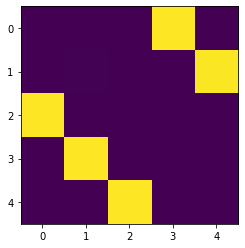

In [ ]:
from mmcls.datasets import build_dataloader, build_dataset
from mmcls.core.evaluation import calculate_confusion_matrix
dataset = build_dataset(cfg.data.test)
pred = mmcv.load("./result.pkl")['class_scores']
matrix = calculate_confusion_matrix(pred, dataset.get_gt_labels())
print(matrix)
import matplotlib.pyplot as plt
plt.imshow(matrix)

In [ ]:
kwargs = {}
eval_kwargs = cfg.get('evaluation', {}).copy()
for key in [
    'interval', 'tmpdir', 'start', 'gpu_collect', 'save_best',
    'rule', 'dynamic_intervals'
]:
    eval_kwargs.pop(key, None)
eval_kwargs.update(dict(metric='accuracy', **kwargs))
metric = dataset.evaluate(outputs, **eval_kwargs)
print(metric)

{'accuracy_top-1': 20.0}


In [ ]:
eval_kwargs

{'metric': 'accuracy', 'metric_options': {'topk': (1,)}}

In [ ]:
# cfg = Config.fromfile('./configs/detr/detr_r50_8x2_150e_coco.py')
cfg = Config.fromfile('configs/mobilenet_v2/mobilenet-v2_8xb32_in1k.py')
# replace the ${key} with the value of cfg.key
# cfg = replace_cfg_vals(cfg)
# model = model.cfg
# update data root according to MMDET_DATASETS


NameError: ignored

In [ ]:
# build the dataloader
distributed = False

test_dataloader_default_args = dict(
    samples_per_gpu=1, workers_per_gpu=1, dist=distributed, shuffle=False)

test_loader_cfg = {
    **test_dataloader_default_args,
    **cfg.data.get('test_dataloader', {})
 }
model = build_classifier(cfg.model)
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(dataset, **test_loader_cfg)

In [ ]:
outputs = mmcls.apis.single_gpu_test(model, data_loader, show=False, out_dir=None)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1000/1000, 13.7 task/s, elapsed: 73s, ETA:     0s

In [ ]:
for key in ['interval', 'tmpdir', 'start', 'gpu_collect', 'save_best','rule', 'dynamic_intervals']:
  eval_kwargs.pop(key, None)

In [ ]:
dataset = [build_dataset(cfg.data.val)]

In [ ]:
eval_kwargs.update(dict(metric='accuracy', **kwargs))
metric = dataset.evaluate(outputs, **eval_kwargs)

AttributeError: ignored